In [1]:
from __future__ import print_function
import pickle
import os
import sys
import matplotlib.pyplot as plt
import time
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import capsules
from loss import SpreadLoss
from datasets import smallNORB
#########################
seed = 1
cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
#########################
batch_size, test_batch_size = 32, 128
num_class = 5
data_folder = './data'
dataset = 'smallNORB'
init_lr = 3e-3 # moein - according to openreview
weight_decay = 2e-7  # moein - according to openreview
log_interval = 100
test_interval = 1
epochs = 150
snapshot_folder = 'caps_train_v3'
test_code = False # moein - for checking the functions. If True, model will run one step.
log_test = False # moein - for getting logs
#########################
# moein - checked with IBM transformations
def get_setting():
    cuda = torch.cuda.is_available()
    kw = {'num_workers': 8, 'pin_memory': True} if cuda else {}
    path = os.path.join(data_folder, dataset)
    
    train_loader = torch.utils.data.DataLoader(
        smallNORB(path, train=True, download=True,
                  transform=transforms.Compose([
                      transforms.Resize(48),
                      transforms.RandomCrop(32),
                      transforms.ColorJitter(brightness=32./255, contrast=0.5),
                      transforms.ToTensor()
                                          
                  ])),
        batch_size = batch_size, shuffle=True, **kw)
    
    test_loader = torch.utils.data.DataLoader(
        smallNORB(path, train=False,
                  transform=transforms.Compose([
                      transforms.Resize(48),
                      transforms.CenterCrop(48),
                      transforms.ToTensor()
#                       ,transforms.Normalize(mean=[data_mean],std=[data_std])
                  ])),
        batch_size = test_batch_size, shuffle=False,**kw)
    
    return train_loader, test_loader

#### defining a function for showing some samples from the data

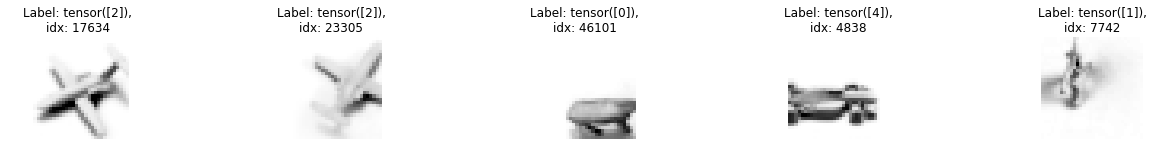

In [3]:

import random
def plot_gallery(imgs,image_size=32,num=5,class_idx=False):
    plt.figure(figsize=(20,6))
    for idx in range(num) :
        if class_idx:
            i = idx
        else:
            rand = random.randint(1,len(imgs))
            i = idx+rand
        img_ = imgs[i][0]
        label = imgs[i][1]
        plt.subplot(1, num, idx+1)
        plt.axis('off')
        plt.imshow(img_.reshape(img_.shape[1],img_.shape[2]),cmap='Greys_r')
        plt.subplots_adjust(wspace=1.5)
        plt.title("Label: {0},\nidx: {1}".format(label,i))

plot_gallery(train_loader.dataset,class_idx=False)

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(train_loader, model, criterion, optimizer, epoch, device, previous_epochs=0, ext_decay= 1):
    
    ''' * exponential learning rate decay added'''
    
    batch_time = AverageMeter()
    data_time = AverageMeter()

    model.train()
    train_len = len(train_loader)
    epoch_acc = 0
    i=0
    for batch_idx, (data, target) in enumerate(train_loader):
        i += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        r = (1.*batch_idx + (previous_epochs+epoch-1) * train_len) / ((previous_epochs+epochs)*train_len) # moein - used in criterion
        
        loss = criterion(output, target, r)        
        acc = accuracy(output, target)
        
        global_step = (batch_idx+1) + (previous_epochs + epoch - 1) * len(train_loader) # moein
        exp_lr_decay(optimizer = optimizer, global_step = global_step, ext_decay = ext_decay) # moein - change the learning rate exponentially
        
        if log_test:
            for param_group in optimizer.param_groups:
                print('optim lr:',param_group['lr'])
                print('step:',global_step)
        
        loss.backward()
        optimizer.step()
        epoch_acc += acc[0].item()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}\t[{}/{} ({:.0f}%)]\t'
                  'Loss: {:.6f}\tAccuracy: {:.6f}\t'.format(
                  epoch+previous_epochs, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item(), acc[0].item()))
            
        if test_code: return epoch_acc

    return epoch_acc

def test(test_loader, model, criterion, device,prop=1):
    model.eval()
    test_loss = 0
    acc = 0
    test_len = len(test_loader)
    with torch.no_grad():
        i = 0
        for data, target in test_loader:
            if i >(test_len//prop):break
            progressBar(job='Test',value=i, endvalue=test_len//prop); i += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, r=1).item()
            acc += accuracy(output, target)[0].item()
            if test_code: return acc

    test_loss /= test_len
    acc /= test_len
    print('\nTest set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
        test_loss, acc))
    return acc


In [5]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# function for saving the weights
def snapshot(model, folder, epoch, name):
    path = os.path.join(folder, 'model_{}_{}.pth'.format(name,epoch))
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    print('\nsaving model to {}'.format(path))
    torch.save(model.state_dict(), path)
    
def exp_lr_decay(optimizer, global_step, init_lr = 3e-3, decay_steps = 20000,
                                        decay_rate = 0.96, lr_clip = 3e-3 ,ext_decay = 1, staircase=False):
    
    ''' decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)  '''
    
    if staircase:
        lr = (init_lr * decay_rate**(global_step // decay_steps)) * ext_decay
    else:
        lr = (init_lr * decay_rate**(global_step / decay_steps)) * ext_decay
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# showing the training progress in each epoch
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [6]:
# main training function
# in this function wecall the train() for each epoch
def mainTrain(name, epochs, model, history, optimizer, tolarance = 12, 
              previous_epochs = 0, best_acc= 0, init_decay_fac = 1,LR_decay_fac= 0.1 , best_epoch = 1):
    best_acc = best_acc
    best_epoch = best_epoch
    t, t1 = tolarance , tolarance
    noImp = 0
    decay_factor = init_decay_fac # moein - when training reaches the tolarance threshold, lr will be multiplied by this.
                                # inintial value of it is 1
    print('########### Training model {} ###########'.format(name))
    for epoch in range(1, epochs + 1):
        start=time.time()
        noImp = (epoch + previous_epochs) - best_epoch
        
        acc = train(train_loader, model, criterion, optimizer, epoch, device, previous_epochs,ext_decay=decay_factor)
        acc /= len(train_loader)

        history['acc'].append(acc)        
        print('Epoch Train-Accuracy : {:.4f}'.format(acc))
                
        if epoch % test_interval == 0:
            test_acc = test(test_loader, model, criterion, device)
            history['val_acc'].append(test_acc)
            best_acc = max(best_acc,test_acc )
            
            
        snapshot(model, snapshot_folder, epoch+previous_epochs,name)
        
        end=time.time()
        for param_group in optimizer.param_groups:
            print('Current Learning Rate : {}'.format(param_group['lr']))
        
        
        if test_code == True: return best_acc
            
        if test_acc < best_acc:
            tolarance -= 1
            if tolarance < 0:
                print('{} epochs with no improvement. Multiplying LR by {}'.format(t,LR_decay_fac))
                t = t//2
                if t<4: t+=3
                tolarance = t # moein - reset tolarence
                decay_factor *= LR_decay_fac 
        else :
            best_epoch = epoch + previous_epochs
            tolarance = t
            
        print('* Best val Accuracy so far : {:.3f} epoch : {} *'.format(best_acc,best_epoch))
        print('{} epochs with no improvement in val_acc.'.format(noImp))
        
        if noImp == 30 :
            print('Model has converged. Existing the training.')
            return best_acc
        
        print('Epoch time: {:.2f} mins'.format((end-start)/60))
        print('='*80)

    print('########### Training model {} finished ###########'.format(name))
    return best_acc

In [7]:
device = torch.device("cuda" if cuda else "cpu")
A, B, C, D = 64, 8, 16, 16
criterion = SpreadLoss(num_class=5, m_min=0.2, m_max=0.9)

#### model 2 2 2

In [10]:
# model
torch.cuda.empty_cache()    
best_acc222 = 0
em_iters = [2,2,2]
model222 = capsules(A=A, B=B, C=C, D=D, E=num_class,
                 iters_routings=em_iters).to(device)
history222={'val_acc':[],'acc':[]}
optimizer222 = optim.Adam(model222.parameters(), lr = init_lr, weight_decay = weight_decay)

model info: 
A, B, C, D, E, P, K = [64, 8, 16, 16, 5, 3, 4] 
iters for routings:  [2, 2, 2] 
stage output:  class_caps 
activation:  o


In [48]:
torch.cuda.empty_cache()
# the training was onced stopped accidentally, so i used the the arguments of the mainTrain to continue
# the process if you want to have a fresh training just leave all the arguments to default.
best_acc222= mainTrain('model222_A',epochs,model222,history222,optimizer222,tolarance=12,
                       previous_epochs=101,best_acc=89.9198 ,noImp=12, init_decay_fac=0.1, best_epoch = 88)

########### Training model model222_A ###########
Train Epoch: 102	[0/48600 (0%)]	Loss: 0.000073	Accuracy: 100.000000	
Train Epoch: 102	[3200/48600 (7%)]	Loss: 0.000626	Accuracy: 100.000000	
Train Epoch: 102	[6400/48600 (13%)]	Loss: 0.001127	Accuracy: 100.000000	
Train Epoch: 102	[9600/48600 (20%)]	Loss: 0.000591	Accuracy: 100.000000	
Train Epoch: 102	[12800/48600 (26%)]	Loss: 0.003729	Accuracy: 100.000000	
Train Epoch: 102	[16000/48600 (33%)]	Loss: 0.001311	Accuracy: 100.000000	
Train Epoch: 102	[19200/48600 (39%)]	Loss: 0.000566	Accuracy: 100.000000	
Train Epoch: 102	[22400/48600 (46%)]	Loss: 0.003009	Accuracy: 100.000000	
Train Epoch: 102	[25600/48600 (53%)]	Loss: 0.000130	Accuracy: 100.000000	
Train Epoch: 102	[28800/48600 (59%)]	Loss: 0.000193	Accuracy: 100.000000	
Train Epoch: 102	[32000/48600 (66%)]	Loss: 0.000529	Accuracy: 100.000000	
Train Epoch: 102	[35200/48600 (72%)]	Loss: 0.000123	Accuracy: 100.000000	
Train Epoch: 102	[38400/48600 (79%)]	Loss: 0.000596	Accuracy: 100.00000

Train Epoch: 107	[6400/48600 (13%)]	Loss: 0.001394	Accuracy: 100.000000	
Train Epoch: 107	[9600/48600 (20%)]	Loss: 0.000627	Accuracy: 100.000000	
Train Epoch: 107	[12800/48600 (26%)]	Loss: 0.000019	Accuracy: 100.000000	
Train Epoch: 107	[16000/48600 (33%)]	Loss: 0.000090	Accuracy: 100.000000	
Train Epoch: 107	[19200/48600 (39%)]	Loss: 0.000052	Accuracy: 100.000000	
Train Epoch: 107	[22400/48600 (46%)]	Loss: 0.000287	Accuracy: 100.000000	
Train Epoch: 107	[25600/48600 (53%)]	Loss: 0.001331	Accuracy: 100.000000	
Train Epoch: 107	[28800/48600 (59%)]	Loss: 0.000039	Accuracy: 100.000000	
Train Epoch: 107	[32000/48600 (66%)]	Loss: 0.000385	Accuracy: 100.000000	
Train Epoch: 107	[35200/48600 (72%)]	Loss: 0.000542	Accuracy: 100.000000	
Train Epoch: 107	[38400/48600 (79%)]	Loss: 0.000844	Accuracy: 100.000000	
Train Epoch: 107	[41600/48600 (86%)]	Loss: 0.000754	Accuracy: 100.000000	
Train Epoch: 107	[44800/48600 (92%)]	Loss: 0.002060	Accuracy: 100.000000	
Train Epoch: 107	[48000/48600 (99%)]	Los

Train Epoch: 112	[12800/48600 (26%)]	Loss: 0.000211	Accuracy: 100.000000	
Train Epoch: 112	[16000/48600 (33%)]	Loss: 0.000291	Accuracy: 100.000000	
Train Epoch: 112	[19200/48600 (39%)]	Loss: 0.000131	Accuracy: 100.000000	
Train Epoch: 112	[22400/48600 (46%)]	Loss: 0.001994	Accuracy: 100.000000	
Train Epoch: 112	[25600/48600 (53%)]	Loss: 0.000308	Accuracy: 100.000000	
Train Epoch: 112	[28800/48600 (59%)]	Loss: 0.000151	Accuracy: 100.000000	
Train Epoch: 112	[32000/48600 (66%)]	Loss: 0.000667	Accuracy: 100.000000	
Train Epoch: 112	[35200/48600 (72%)]	Loss: 0.010190	Accuracy: 100.000000	
Train Epoch: 112	[38400/48600 (79%)]	Loss: 0.000440	Accuracy: 100.000000	
Train Epoch: 112	[41600/48600 (86%)]	Loss: 0.000390	Accuracy: 100.000000	
Train Epoch: 112	[44800/48600 (92%)]	Loss: 0.000344	Accuracy: 100.000000	
Train Epoch: 112	[48000/48600 (99%)]	Loss: 0.000166	Accuracy: 100.000000	
Epoch Train-Accuracy : 99.9047
Test Completion: [------------------->] 100%
Test set: Average loss: 0.598367, Ac

Train Epoch: 117	[19200/48600 (39%)]	Loss: 0.000671	Accuracy: 100.000000	
Train Epoch: 117	[22400/48600 (46%)]	Loss: 0.000547	Accuracy: 100.000000	
Train Epoch: 117	[25600/48600 (53%)]	Loss: 0.005879	Accuracy: 100.000000	
Train Epoch: 117	[28800/48600 (59%)]	Loss: 0.001312	Accuracy: 100.000000	
Train Epoch: 117	[32000/48600 (66%)]	Loss: 0.000895	Accuracy: 100.000000	
Train Epoch: 117	[35200/48600 (72%)]	Loss: 0.000374	Accuracy: 100.000000	
Train Epoch: 117	[38400/48600 (79%)]	Loss: 0.000384	Accuracy: 100.000000	
Train Epoch: 117	[41600/48600 (86%)]	Loss: 0.001242	Accuracy: 100.000000	
Train Epoch: 117	[44800/48600 (92%)]	Loss: 0.000447	Accuracy: 100.000000	
Train Epoch: 117	[48000/48600 (99%)]	Loss: 0.018879	Accuracy: 96.875000	
Epoch Train-Accuracy : 99.9198
Test Completion: [------------------->] 100%
Test set: Average loss: 0.577934, Accuracy: 91.575396 


saving model to caps_train_v3\model_model222_A_117.pth
Current Learning Rate : 2.0872802903291093e-05
Epoch time: 16.68 mins
Bes

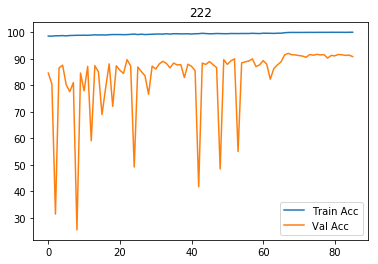

In [51]:
# last 20 epochs
plt.title('222')
plt.plot(history222['acc'])
plt.plot(history222['val_acc'])
plt.legend(['Train Acc','Val Acc'])
plt.show()

* Best val Accuracy so far : 91.99891596342388 epoch : 103